In [1]:
from Levenshtein import distance
import numpy as np
import json
dataset = [json.loads(line)for line in open("mrc_interpretation_B.txt").readlines()]


In [2]:
import re
for data in dataset:
    if '最大公因数' in data['context']:
        data['context'] = data['context'][:10]
        continue
    elif '整数' in data['context']:
        data['context'] = data['context'][len(data['context'])-10:]
        data['context'] = data['context'].replace('因数有哪些','')
        continue
    elif '一起吃' in data['context']:
        data['context'] = data['context'][:20]
        data['context'] = data['context'].replace('一起吃','')
        continue
    elif '氧化' in data['context'] and '酸性' in data['context']:
        data['context'] = data['context'][:10]
        data['context'] = data['context'].replace('反应','')
        continue
    elif '国家' in data['context'] and '保险' in data['context']:
        data['context'] = data['context'][:10]
        # data['context'] = data['context'].replace('反应','')
        continue
    elif '歌曲：' in data['context']:
        data['context'] = data['context'][:10]
        # data['context'] = data['context'].replace('反应','')
        continue
    data['context'] = data['context'].replace('_百度知道','')
    data['context'] = data['context'].replace('_有问必答_快速问医生','')
    data['context'] = data['context'].replace('_39健康问答_39健康网', '')
    data['context'] = data['context'].replace('你好', '')
    data['context'] = data['context'].replace('1.','')
    data['context'] = data['context'].replace('2.','')
    data['context'] = data['context'].replace('3.','')
    data['context'] = data['context'].replace('一样','')
    # data['context'] = data['context'].replace('一起吃','')
    data['context'] = data['context'].replace('是一个汉语词汇','')
    data['context'] = data['context'].replace('拼音', '')
    data['context'] = data['context'].replace('笔画', '')
    # data['context'] = data['context'].replace('最大公因数','')
    data['context'] = data['context'].replace('病情分析: ','')
    data['context'] = data['context'].replace('指导意见: ','')
distance_mat = np.zeros((len(dataset),len(dataset)))
for i in range(len(dataset)):
    text1 = dataset[i]['context']
    for j,data in zip(range(i,len(dataset)),dataset[i:]):
        text2 = data['context']
        # normalize levenshtein distance
        distance_mat[i][j] = distance(text1,text2) / (len(text1)+len(text2))
        distance_mat[j][i] = distance_mat[i][j]

(array([1.2500e+02, 6.0000e+00, 2.0000e+00, 9.0000e+00, 3.0000e+00,
        0.0000e+00, 4.0000e+00, 1.0000e+00, 5.0000e+00, 0.0000e+00,
        3.0000e+00, 4.0000e+00, 1.0000e+00, 5.0000e+00, 2.0000e+00,
        2.0000e+00, 1.0000e+00, 2.0000e+00, 1.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 3.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        1.0000e+00, 0.0000e+00, 2.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        1.0000e+00, 7.0000e+00, 1.1000e+01, 1.3000e+01, 9.0000e+00,
        3.5000e+01, 2.3000e+01, 6.1000e+01, 1.3900e+02, 7.7900e+02,
        5.0750e+03, 1.3913e+04, 1.3115e+04, 1.1319e+04, 1.0465e+04,
        9.9070e+03, 9.5090e+03, 9.5940e+03, 8.6310e+03, 8.3690e+03,
        7.5150e+03, 7.2010e+03, 6.3060e+03, 5.8270e+03, 5.3930e+03,
        4.9340e+03, 4.3250e+03, 3.8300e+03, 3.7180e+03, 3.2360e+03,
        2.8540e+03, 2.5560e+03, 2.3590e+03, 1.92

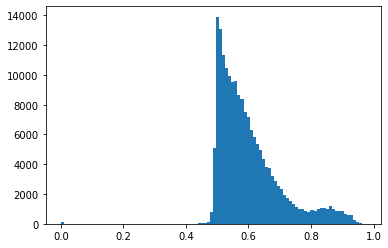

In [3]:
# the distribution of levenshtein distance
mat_ele = distance_mat.flatten()
import matplotlib.pyplot as plt
plt.hist(mat_ele[:1855*100],bins=100)

In [4]:
fails = []
success = set()
threshold = 0.27 # setting the threshold to the 0.27
unpair_set = set()
paired_set = set()
from tqdm import tqdm
for i in tqdm(range(len(distance_mat))):
    pairs_index = np.where(distance_mat[i]<threshold)[0]
    if len(pairs_index) == 1 and i not in paired_set:
        unpair_set.add(i)
        continue
    mark = True
    # ensure all set are equal in one group
    for idx in pairs_index:
        dst = np.where(distance_mat[idx]<threshold)[0]
        # not equal drop the group use the human to check
        if len(dst) != len(pairs_index) or not (dst == pairs_index).all():
            fails.append((i,dst,pairs_index))
            mark = False
    if mark:
        success.add(tuple(pairs_index.tolist()))
        paired_set = paired_set.union(set(pairs_index))
    else:
        unpair_set.add(i)

full_set = set(list(range(len(dataset))))
done_set = unpair_set.union(paired_set)
assert done_set == full_set, print(full_set - done_set)
print(len(unpair_set))
print(len(fails))

100%|██████████| 4366/4366 [00:00<00:00, 15163.70it/s]

228
88


In [5]:
print(len(paired_set))

4138


In [6]:
success = [list(suc) for suc in success]
success.sort(key=lambda x:x[0])
with open('pair_B.json','w') as f:
    for suc in success:
        f.write(json.dumps(suc)+'\n')

In [7]:
unpair_set = list(unpair_set)
unpair_set.sort()
human_checks2 = set()
human_checks1 = set()
for idx in unpair_set:
    print(idx)
    print(dataset[idx]['context'])
    dst = np.where(distance_mat[idx]<0.45)[0] # allivate the threhold get more match
    if len(dst) >= 2:
        human_checks2.add(tuple(dst.tolist()))
    else:
        # even worse
        # need human to find pairs for these data
        human_checks1.add(idx)
    print(json.dumps(dst.tolist()))
    print(json.dumps([dataset[j]['context'] for j in dst],indent=4,ensure_ascii=False))
    print()
human_checks2 = [list(suc) for suc in human_checks2]
human_checks2.sort(key=lambda x:x[0])
# human to check the pair is right or not
with open('human_2_B.json','w') as f:
    for suc in human_checks2:
        f.write(json.dumps(suc)+'\n')

31
网球运动的起源及演变可以用四句话来概括：网球孕育在法国，诞生在英国，开始普及和形成高潮在美国，现盛行全世界。
[31, 2086]
[
    "网球运动的起源及演变可以用四句话来概括：网球孕育在法国，诞生在英国，开始普及和形成高潮在美国，现盛行全世界。",
    "网球与高尔夫、保龄球、桌球并称为世界四大绅士运动，他的起源可以追溯到12-13世纪的法国。网球运动的起源及演变可以用四句话来概括：网球孕育在法国，诞生在英国，开始普及和形成高潮在美国，现盛行全世界。"
]

100
亳州,别称焦邑、谯城,安徽省下辖地级市,位于安徽省西北部,全市总人口534万人。市辖区面积2226平方公里,人口130万。亳州是一座历史悠久的古城,新石器时代就有人类在此活动。自秦时置谯县以来,历经朝代更迭,大都系州、郡或县建制,其间魏皇初二年(221年)封谯郡为 “陪都”。元至正15年(1355),刘福通起兵反元,拥韩林儿在亳州称帝,建“宋”政权,以亳州为国都。亳州成为三朝古都之地。毫州是哪个省的
[100, 458, 1064, 2175, 2738, 3369]
[
    "亳州,别称焦邑、谯城,安徽省下辖地级市,位于安徽省西北部,全市总人口534万人。市辖区面积2226平方公里,人口130万。亳州是一座历史悠久的古城,新石器时代就有人类在此活动。自秦时置谯县以来,历经朝代更迭,大都系州、郡或县建制,其间魏皇初二年(221年)封谯郡为 “陪都”。元至正15年(1355),刘福通起兵反元,拥韩林儿在亳州称帝,建“宋”政权,以亳州为国都。亳州成为三朝古都之地。毫州是哪个省的",
    "亳州,别称焦邑、谯城,安徽省下辖地级市,位于安徽省西北部,全市总人口534万人。市辖区面积2226平方公里,人口130万。亳州是一座历史悠久的古城,新石器时代就有人类在此活动。自秦时置谯县以来,历经朝代更迭,大都系州、郡或县建制,其间魏皇初二年(221年)封谯郡为 “陪都”。元至正15年(1355),刘福通起兵反元,拥韩林儿在亳州称帝,建“宋”政权,以亳州为国都。亳州成为三朝古都之地。毫州是哪个省的",
    "亳州,别称焦邑、谯城,安徽省下辖地级市,位于安徽省西北部,全市总人口534万人。市辖区面积2226平方公里,人口130万。亳州是一座历史悠久的古城,新石器时代就有人类在此活动。自秦时置

In [8]:
print(len(human_checks1))

34


In [9]:
human_checks1 = list(human_checks1)
human_checks1.sort()

for idx in human_checks1:
    print(idx)
    print(dataset[idx]['context'])
    dst = np.where(distance_mat[idx]<0.40)[0]
    print(json.dumps(dst.tolist()))
    print(json.dumps({str(j):dataset[j]['context'] for j in dst},indent=4,ensure_ascii=False))
    print()

with open('human_1_B.json','w') as f:
    for idx in human_checks1:
        f.write(json.dumps([idx])+'\n')

215
弗里德里克·弗朗索瓦·肖邦 19世纪波兰作曲家、钢琴家主要作品有：钢琴协奏曲2首、钢琴三重奏、钢琴奏鸣曲3首、叙事曲4首。
[215]
{
    "215": "弗里德里克·弗朗索瓦·肖邦 19世纪波兰作曲家、钢琴家主要作品有：钢琴协奏曲2首、钢琴三重奏、钢琴奏鸣曲3首、叙事曲4首。"
}

440
这个说一不二的话,算是的好的。女孩说一不二性格好吗?
[440]
{
    "440": "这个说一不二的话,算是的好的。女孩说一不二性格好吗?"
}

510
大专学历现在是可以考研究生的，但是要专科毕业后工作满两年后才可以考，并且要有国家承认的专科学历才可以大专学历可以考研究生吗 条件是什么
[510]
{
    "510": "大专学历现在是可以考研究生的，但是要专科毕业后工作满两年后才可以考，并且要有国家承认的专科学历才可以大专学历可以考研究生吗 条件是什么"
}

532
文艺 Literature and art：文学和艺术，有时指文学或表演艺术，是人们对生活的提炼，升华和表达。文艺的开始意味着人类的文艺复兴，人类将重新发现了人和人格的伟大，肯定了人的价值和能力，提出人要养育人格，个性应该智慧；一致幸福的求实精神，对人首先要研究个究竟，决不满足于对其他事物的一知半解，为创造现实幸福生活而奋斗的乐观进取精神，把人从以往历史、民族、宗教、地域等诸多划分的桎梏下解放出来。
[532]
{
    "532": "文艺 Literature and art：文学和艺术，有时指文学或表演艺术，是人们对生活的提炼，升华和表达。文艺的开始意味着人类的文艺复兴，人类将重新发现了人和人格的伟大，肯定了人的价值和能力，提出人要养育人格，个性应该智慧；一致幸福的求实精神，对人首先要研究个究竟，决不满足于对其他事物的一知半解，为创造现实幸福生活而奋斗的乐观进取精神，把人从以往历史、民族、宗教、地域等诸多划分的桎梏下解放出来。"
}

544
胶片就是银盐感光胶片，也叫菲林。由PC/PP/PET/PVC料制作而成。胶片一般是指胶卷，也可以指印刷制版中的底片。菲林都是黑色的，菲林的边角一般有一个英文的符号，是菲林的编号，标明该菲林是C、M、Y、K中的哪一张，是cmyk的其中一个（或专色号），表示这张菲林是什么色输出的，如果没有，可以看挂网的角度，来辨别是什么色。
[544

In [10]:
import json
from pathlib import Path
file_list = ['pair_B.json','human_2_B.json','human_1_B.json']
init_group = {
    'pair_B':[],
    'human_2_B':[],
    'human_1_B':[],
}
for file in file_list:
    file_stem = Path(file).stem
    for line in open(file).readlines():
        init_group[file_stem].append(json.loads(line))
# import json
dataset = [json.loads(line)for line in open("mrc_interpretation_B.txt").readlines()]

In [11]:
check_set = set()
for data in init_group['pair_B']:
    for ele in data:
        if ele not in check_set:
            check_set.add(ele)
        else:
            print(ele)

In [12]:
def check_in_pair(data:list):
    ret = set()
    for ele in data:
        if ele in check_set:
            for unit_group in init_group['pair_B']:
                if ele in unit_group:
                    ret.add(tuple(unit_group))
                    
    return ret

In [13]:
match_result = {
    'human_2_B':{},
    'human_1_B':{}
}
for k in ['human_2_B','human_1_B']:
    for data in  init_group[k]:
        match_group = check_in_pair(data)
        if len(match_group) > 0:
            match_result[k][tuple(data)] = match_group
        
final_group = []
final_set = set()
for _,results in match_result.items():
    for k,v in results.items():
        unit_group = set(k)
        for auto_group in v:
            unit_group = unit_group.union(set(auto_group))
        final_group.append(list(unit_group))
        final_set = final_set.union(unit_group)
for _,unit_groups in init_group.items():
    for unit_group in unit_groups:
        if len(set(unit_group).intersection(final_set)) == 0:
            final_group.append(unit_group) 
            final_set = final_set.union(set(unit_group))

assert set(list(range(len(dataset)))) == final_set

final_group.sort(key=lambda x:x[0])
refine_dataset = [[dataset[idx] for idx in group] for group in final_group]
with open('refine_dataset.json','w') as f:
    json.dump(refine_dataset,f,indent=4,ensure_ascii=False)
